In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import time
import os
import sys
import copy
import time
import datetime
import random
import math
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

In [4]:
import matplotlib
# mpl.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap

matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 5
plt.rcParams['figure.figsize'] = [4, 4]

In [5]:
import numpy as np
import scipy
import seaborn as sns

from tqdm.notebook import tqdm, trange

In [6]:
sys.path.append("../")

In [7]:
from chaosmining.data_utils import read_formulas, create_simulation_data
from chaosmining.simulation.models import MLPRegressor

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [9]:
from captum.attr import IntegratedGradients, Saliency, DeepLift, FeatureAblation

# Generate Functions and Data

In [10]:
formulas_path = '../data/symbolic_simulation/formula.csv'

In [11]:
formulas = read_formulas(formulas_path)

In [12]:
formula_id = 8
seed = 42
test_size = 0.2
n_steps = 20

In [13]:
num_features, function = formulas[formula_id]

In [14]:
num_noises = 10
num_data = 10000
X_var = 0.33
y_var = 0.01
X, y_true, y_noise, intercepts, derivatives, integrations = create_simulation_data(function, num_features, num_noises, num_data, X_var, y_var, n_steps=n_steps)
print('X', X.shape, 'y true', y_true.shape, 'y noise', y_noise.shape, 
      'intercepts', len(intercepts), intercepts[0].shape,
      'derivatives', len(derivatives), derivatives[0].shape, 
      'integrations', len(integrations), integrations[0].shape)

X (10000, 14) y true (10000, 1) y noise (10000, 1) intercepts 4 (10000,) derivatives 4 (10000,) integrations 4 (10000,)


In [15]:
intercepts = np.stack(intercepts, axis=1)
derivatives = np.stack(derivatives, axis=1)
integrations = np.stack(integrations, axis=1)

In [16]:
y = y_true + y_noise

In [17]:
X_train, X_test, \
y_train, y_test, \
y_true_train, y_true_test, \
intercepts_train, intercepts_test, \
derivatives_train, derivatives_test, \
integrations_train, integrations_test \
= train_test_split(X, y, y_true, intercepts, derivatives, integrations, test_size=test_size, random_state=seed)

# Training and Test a MLP

In [18]:
train_set = TensorDataset(Tensor(X_train), Tensor(y_train))
train_loader = DataLoader(train_set, batch_size=y_train.shape[0], shuffle=True)
test_set = TensorDataset(Tensor(X_test), Tensor(y_test))
test_loader = DataLoader(test_set, batch_size=y_test.shape[0])

In [19]:
hidden_layer_sizes = (100,100,100)
num_epochs = 1000

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
model = MLPRegressor(num_features+num_noises, hidden_layer_sizes, p=0.0)
model.to(device)
model.train()

MLPRegressor(
  (blocks): ModuleList(
    (0): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=14, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (1): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (2): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (project): Linear(in_features=100, out_features=1, bias=True)
)

In [22]:
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), 0.001)

In [23]:
def train(model, dataloader, num_epochs, optimizer):
    pbar = trange(num_epochs, desc='Train', unit='epoch', initial=0)
    for epoch in pbar:  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # forward pass
            outputs = model(inputs)
            # defining loss
            loss = criterion(outputs, targets)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        pbar.set_postfix(loss = '%.3f' % running_loss)

In [24]:
train(model, train_loader, num_epochs, optimizer)

Train:   0%|          | 0/1000 [00:00<?, ?epoch/s]

In [25]:
y_pred = model(Tensor(X_test).to(device)).detach().cpu().numpy()

In [26]:
score = mean_absolute_error(y_pred, y_test)
print('Test mean absolute value is', score)

Test mean absolute value is 0.023997863052001918


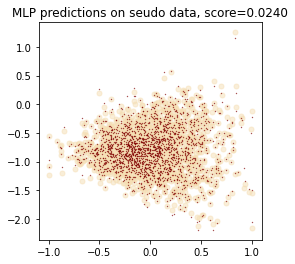

In [27]:
plt.scatter(X_test[:,0], y_test, c='wheat', alpha=0.5)
plt.scatter(X_test[:,0], y_pred, s=0.1, c='maroon', alpha=1)
plt.title(f"MLP predictions on seudo data, score={score:.4f}")
plt.show()

# Generate Local Explanations

In [28]:
dl = DeepLift(model)
fa = FeatureAblation(model)
sa = Saliency(model)
ig = IntegratedGradients(model)

In [29]:
dl_attr_test = dl.attribute(Tensor(X_test).to(device))

In [30]:
fa_attr_test = fa.attribute(Tensor(X_test).to(device))

In [31]:
sa_attr_test = sa.attribute(Tensor(X_test).to(device))

In [32]:
ig_attr_test = ig.attribute(Tensor(X_test).to(device), n_steps=n_steps)

# Compare Local Explanations with gtrue

## 1. Prediction vs. Target

In [33]:
y_diff = y_pred - y_true_test

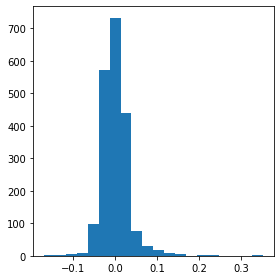

In [34]:
fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)

ax.hist(y_diff, bins=20)
plt.show()

In [35]:
def mean_std_absolute_error(preds, targets):
    abs_diff = np.absolute(preds-targets)
    return np.mean(abs_diff), np.std(abs_diff)

In [36]:
def mean_std_absolute_error_ratio(preds, targets):
    abs_diff = np.absolute(preds-targets)
    abs_targets = np.absolute(targets)
    diff_ratio = abs_diff/abs_targets
    return np.mean(diff_ratio), np.std(diff_ratio)

In [37]:
mean_abs_y_diff, std_abs_y_diff = mean_std_absolute_error(y_pred, y_true_test)

In [38]:
print(f'The mean and standard deviation of absolute error of predictions and targets are \
      {mean_abs_y_diff:.3f} and {std_abs_y_diff:.3f}')

The mean and standard deviation of absolute error of predictions and targets are       0.023 and 0.024


## 2. Top Features Using DeepLift

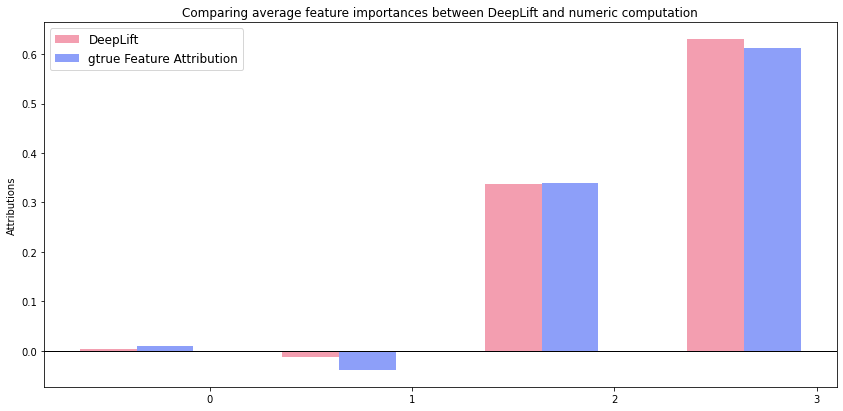

In [39]:
num_feature_show = num_features
x_axis_data = np.arange(num_feature_show)
x_axis_data_labels = list(range(num_feature_show))

dl_attr_test_sum = dl_attr_test.detach().cpu().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

intercepts_test_sum = np.zeros(num_feature_show)
intercepts_test_sum[:num_features] = intercepts_test.sum(0)
intercepts_test_norm_sum = intercepts_test_sum / np.linalg.norm(intercepts_test_sum, ord=1)

width = 0.28
legends = ['DeepLift', 'gtrue Feature Attribution']

plt.figure(figsize=(12, 6))

ax = plt.subplot()
ax.set_title('Comparing average feature importances between DeepLift and numeric computation')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, dl_attr_test_norm_sum[:num_feature_show], width, align='center', alpha=0.6, color='#eb5e7c')
ax.bar(x_axis_data + width, intercepts_test_norm_sum, width, align='center', alpha=0.6, color='#4260f5')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=0)
plt.axhline(y=0, color='black', linestyle='-')
plt.show()

In [40]:
def abs_argmax_topk(arrays, k):
    inds = np.argpartition(np.abs(arrays), -k, axis=-1)[..., -k:]
    return np.flip(inds, axis=-1)

In [41]:
topk_inds = abs_argmax_topk(dl_attr_test.detach().cpu().numpy(), num_features)

In [42]:
def top_features_score(inds, num_features):
    return np.sum(topk_inds<num_features)/np.prod(topk_inds.shape)

In [43]:
score = top_features_score(topk_inds, num_features)
print(f'The score of learning from top {num_features} features is {score:.4f}')

The score of learning from top 4 features is 0.9036


## 3. Attribution from Baselines Using FeatureAblation

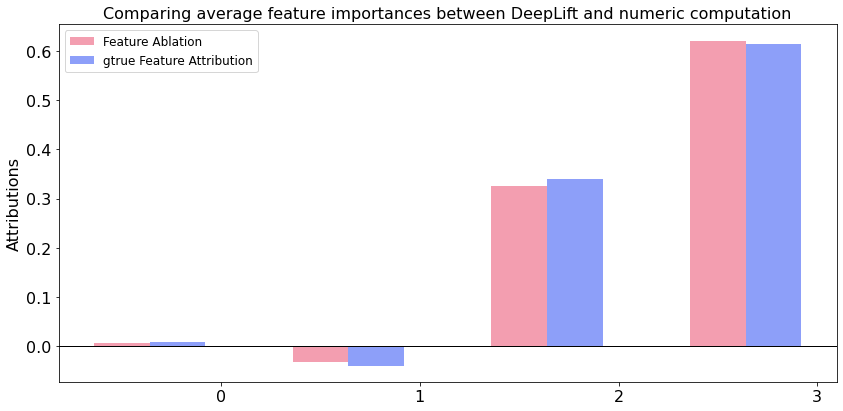

In [44]:
x_axis_data = np.arange(num_feature_show)
x_axis_data_labels = list(range(num_feature_show))

fa_attr_test_sum = fa_attr_test.detach().cpu().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

intercepts_test_sum = np.zeros(num_feature_show)
intercepts_test_sum[:num_features] = intercepts_test.sum(0)
intercepts_test_norm_sum = intercepts_test_sum / np.linalg.norm(intercepts_test_sum, ord=1)

width = 0.28
legends = ['Feature Ablation', 'gtrue Feature Attribution']

plt.figure(figsize=(12, 6))

ax = plt.subplot()
ax.set_title('Comparing average feature importances between DeepLift and numeric computation')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, fa_attr_test_norm_sum[:num_feature_show], width, align='center', alpha=0.6, color='#eb5e7c')
ax.bar(x_axis_data + width, intercepts_test_norm_sum, width, align='center', alpha=0.6, color='#4260f5')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=0)
plt.axhline(y=0, color='black', linestyle='-')
plt.show()

In [45]:
fa_attr_test_rel = fa_attr_test.detach().cpu().numpy()[:,:num_features]

In [46]:
mean_abs_fa_ratio, std_abs_fa_ratio = mean_std_absolute_error_ratio(fa_attr_test_rel, intercepts_test)

In [47]:
print(f'The mean and standard deviation of absolute error of feature ablation and intercepts are \
      {mean_abs_fa_ratio:.3f} and {std_abs_fa_ratio:.3f}')

The mean and standard deviation of absolute error of feature ablation and intercepts are       0.271 and 1.627


## 4. Gradient Using Saliency

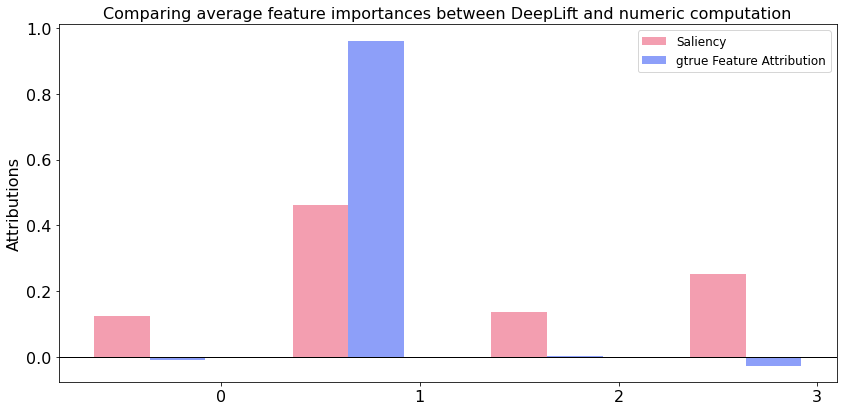

In [48]:
x_axis_data = np.arange(num_feature_show)
x_axis_data_labels = list(range(num_feature_show))

sa_attr_test_sum = sa_attr_test.detach().cpu().numpy().sum(0)
sa_attr_test_norm_sum = sa_attr_test_sum / np.linalg.norm(sa_attr_test_sum, ord=1)

derivatives_test_sum = np.zeros(num_feature_show)
derivatives_test_sum[:num_features] = derivatives_test.sum(0)
derivatives_test_norm_sum = derivatives_test_sum / np.linalg.norm(derivatives_test_sum, ord=1)

width = 0.28
legends = ['Saliency', 'gtrue Feature Attribution']

plt.figure(figsize=(12, 6))

ax = plt.subplot()
ax.set_title('Comparing average feature importances between DeepLift and numeric computation')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, sa_attr_test_norm_sum[:num_feature_show], width, align='center', alpha=0.6, color='#eb5e7c')
ax.bar(x_axis_data + width, derivatives_test_norm_sum, width, align='center', alpha=0.6, color='#4260f5')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=0)
plt.axhline(y=0, color='black', linestyle='-')
plt.show()

In [49]:
sa_attr_test_rel = sa_attr_test.detach().cpu().numpy()[:,:num_features]

In [50]:
mean_abs_sa_ratio, std_abs_sa_ratio = mean_std_absolute_error_ratio(sa_attr_test_rel, derivatives_test)

In [51]:
print(f'The mean and standard deviation of absolute error of sacliency and derivatives are \
      {mean_abs_sa_ratio:.3f} and {std_abs_sa_ratio:.3f}')

The mean and standard deviation of absolute error of sacliency and derivatives are       0.890 and 1.628


## 5. Integration Using IntegratedGradients

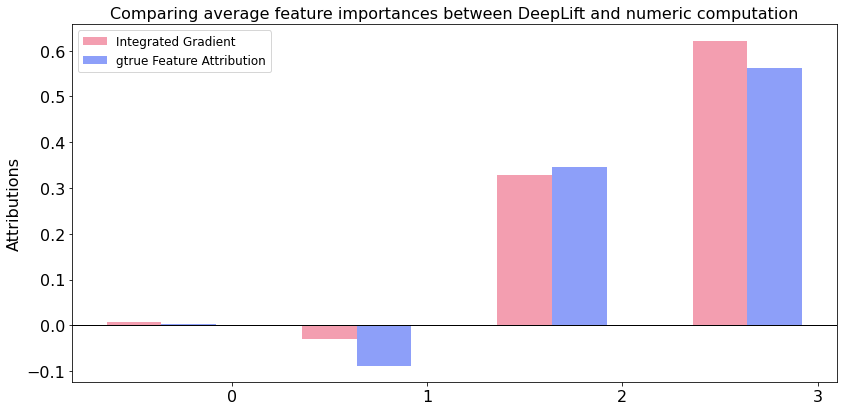

In [52]:
x_axis_data = np.arange(num_feature_show)
x_axis_data_labels = list(range(num_feature_show))

ig_attr_test_sum = ig_attr_test.detach().cpu().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

integrations_test_sum = np.zeros(num_feature_show)
integrations_test_sum[:num_features] = integrations_test.sum(0)
integrations_test_norm_sum = integrations_test_sum / np.linalg.norm(integrations_test_sum, ord=1)

width = 0.28
legends = ['Integrated Gradient', 'gtrue Feature Attribution']

plt.figure(figsize=(12, 6))

ax = plt.subplot()
ax.set_title('Comparing average feature importances between DeepLift and numeric computation')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum[:num_feature_show], width, align='center', alpha=0.6, color='#eb5e7c')
ax.bar(x_axis_data + width, integrations_test_norm_sum, width, align='center', alpha=0.6, color='#4260f5')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=0)
plt.axhline(y=0, color='black', linestyle='-')
plt.show()

In [53]:
integrations_test.shape

(2000, 4)

In [54]:
ig_attr_test_rel = ig_attr_test.detach().cpu().numpy()[:,:num_features]

In [55]:
mean_abs_ig_ratio, std_abs_ig_ratio = mean_std_absolute_error_ratio(ig_attr_test_rel, integrations_test)

In [56]:
print(f'The mean and standard deviation of absolute error of IG and integration are \
      {mean_abs_ig_ratio:.3f} and {std_abs_ig_ratio:.3f}')

The mean and standard deviation of absolute error of IG and integration are       98.272 and 254.602
